<a href="https://colab.research.google.com/github/YoelCanaza/curso-transfer-learning-huggingface/blob/main/my-practice_Computer_vision_con_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visión por computadora con Hugging Face

Así como los modelos basados ​​en Transformers han revolucionado el PLN, ahora vemos una explosión de investigaciones que los aplican a todo tipo de dominios.

Uno de los más revolucionarios fue el Vision Transformer (ViT), que fue presentado en junio de 2021 por un equipo de investigadores de Google Brain.

Usaremos el `Trainer` de Hugging Face para entrenar nuestro modelo de clasificación de imágenes.

Pero antes tenemos que proporcionarle información sobre nuestros datos, el procesamiento de los datos, el modelo, las métricas e información del entrenamiento.

En específico necesitamos definir cada uno de estos puntos:

    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor



## Procesando los datos para visión



Usaremos un Dataset del Hub y lo usaremos para afinar un ViT preentrenado con 🤗 `Transformers`.

### Descargando el dataset

Usaremos el dataset [beans](https://huggingface.co/datasets/beans). Con base en una imagen de una hoja de frijol buscamos predecir si la hoja está saludable o si está enferma. El tipo de enfermedad que tiene (Angular Leaf Spot o Bean Rust).

In [76]:
%%capture
#usamos capture para no tener que ver toda la descarga
!pip install datasets transformers

In [78]:
from datasets import load_dataset # con esto podremos descargar el dataset directamente desde el hub
ds_beans = load_dataset("beans")

In [79]:
ds_beans

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Como vemos, nuestro Dataset es un diccionario con datos train, validation y test. Operar ese dataset es muy similar a operar un array de numpy o un dataframe de pandas.

Miremos un ejemplo.

In [80]:
example = ds_beans["train"][234]
example

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.309.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

Como en la key `image` tenemos una imagen tipo PIL entonces podemos verla.

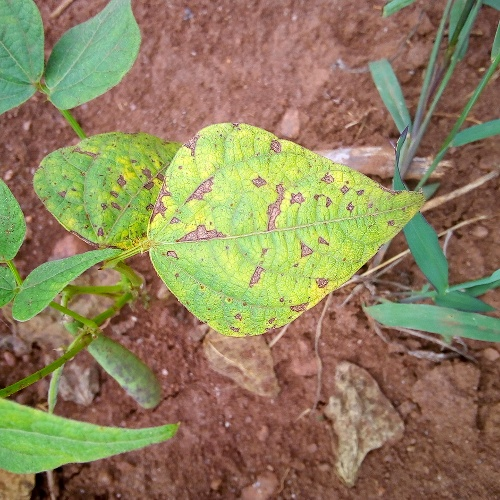

In [81]:
image = example["image"]
image

Aprendamos un poco más sobre las etiquetas en nuestro Dataset. Por ejemplo, notamos que tenemos tres etiquetas.

In [82]:
labels_beans = ds_beans["train"].features["labels"] # sacamos los "labels" del key "features"
labels_beans

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

El método `int2str` de una `ClassLabel` nos permite pasar la representación en número (entero) de la etiqueta y recibir el nombre de la clase.

In [83]:
labels_beans.int2str(example["labels"])

'angular_leaf_spot'

### Cargando el ViT Feature Extractor

Prepararemos estas imágenes para nuestro modelo.

Cuando se entrenan los modelos ViT se aplican transformaciones específicas a las imágenes que se les alimentan. Si usa las transformaciones incorrectas en su imagen, el modelo no entenderá lo que está viendo. 🖼 ➡️

Para asegurarnos de que aplicamos las transformaciones correctas, usaremos un `ViTFeatureExtractor` inicializado con una configuración que se guardó junto con el modelo pre-entrenado que planeamos usar. En nuestro caso usaremos el modelo `google/vit-base-patch16-224-in21k`, así que carguemos su deacture extractor desde el Hub.

Un extractor de características se encarga de preparar las características de los inputs de un modelo.


In [84]:
from transformers import ViTFeatureExtractor
repo_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Puedes ver la configuración del extractor imprimiéndola.

In [85]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



image_mean = mediana, el promedio de la imagen; image_std = desviación estandar de la imagen;  

Para procesar una imagen, simplemente pásala a la función `call` del extractor. Esto devolverá un diccionario que contiene valores de pixeles, que es la representación numérica que se pasará al modelo.

De forma determinada obtenemos una matriz NumPy, pero si agregamos el argumento `return_tensors='pt'`, obtendremos tensores de PyTorch en su lugar.

In [86]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.0902, -0.0980, -0.1451,  ..., -0.3961, -0.3882, -0.3882],
          [-0.1059, -0.1294, -0.1451,  ..., -0.3647, -0.3725, -0.3961],
          [-0.1451, -0.1922, -0.2235,  ..., -0.3176, -0.3333, -0.3647],
          ...,
          [ 0.1059,  0.0353,  0.1686,  ..., -0.2784, -0.3020, -0.2471],
          [ 0.1294,  0.0745,  0.1294,  ..., -0.1059, -0.1216, -0.2549],
          [ 0.2471,  0.1608,  0.2000,  ..., -0.1529, -0.1529, -0.2706]],

         [[ 0.3490,  0.3333,  0.2235,  ..., -0.0039, -0.0118, -0.0039],
          [ 0.3490,  0.3255,  0.2706,  ...,  0.0039, -0.0039, -0.0196],
          [ 0.3255,  0.2941,  0.2392,  ..., -0.0039,  0.0039, -0.0118],
          ...,
          [-0.1059, -0.2000, -0.0824,  ..., -0.5216, -0.5451, -0.4980],
          [-0.0902, -0.1843, -0.1373,  ..., -0.3804, -0.3804, -0.5137],
          [ 0.0275, -0.1059, -0.0667,  ..., -0.4353, -0.4196, -0.5373]],

         [[-0.0353, -0.0275, -0.0824,  ..., -0.1294, -0.1137, -0.1059],
          [-0

Nos regresa un diccionario con una sola key.

Como es un diccionario, podemos operarlo como cualquier otro diccionario de python

In [87]:
feature_extractor(image, return_tensors='pt').keys()

dict_keys(['pixel_values'])

Podemos ver la forma del tensor de pixeles (para tener en mente cómo luce nuestro tensor, cómo luce nuestra imagen convertida a números en el tensor).

In [88]:
feature_extractor(image, return_tensors="pt")["pixel_values"].shape

torch.Size([1, 3, 224, 224])

Vemos que el tensor de pixel values tiene tiene 4 dimensiones, la primera "1" es porque es una única imagen

### Procesando el dataset

Ahora podemos leer imágenes y transformarlas en inputs para nuestro modelo. Escribamos una función que juntará esos dos pasos. Recuerda que `feature_extractor` retorna un diccionario con la key `pixel_values`. Le sumamos una segunda key con las etiquetas `labels`.

In [89]:
def process_example(example):
  inputs = feature_extractor(example["image"], return_tensors="pt")
  inputs["labels"] = example["labels"]
  return inputs

Así se ve un ejemplo procesado de esta manera.

In [90]:
process_example(ds_beans["train"][19])

{'pixel_values': tensor([[[[-0.0353,  0.1843,  0.3725,  ...,  0.5373,  0.3725,  0.3098],
          [-0.0431,  0.0745,  0.3098,  ...,  0.4902,  0.3961,  0.3569],
          [ 0.1216,  0.0745,  0.2392,  ...,  0.3647,  0.4039,  0.4196],
          ...,
          [ 0.5216,  0.5686,  0.6392,  ..., -0.5529,  0.1373,  0.4667],
          [ 0.6000,  0.5765,  0.5922,  ..., -0.6235,  0.1216,  0.5529],
          [ 0.5843,  0.5529,  0.5608,  ..., -0.5686,  0.0902,  0.5922]],

         [[-0.1137,  0.1294,  0.3176,  ...,  0.5686,  0.3569,  0.2784],
          [-0.1529, -0.0118,  0.2314,  ...,  0.4824,  0.3725,  0.3333],
          [ 0.0118, -0.0118,  0.1608,  ...,  0.3255,  0.3961,  0.4118],
          ...,
          [ 0.1686,  0.2235,  0.3176,  ..., -0.3176,  0.3961,  0.7725],
          [ 0.2627,  0.2314,  0.2471,  ..., -0.4196,  0.3569,  0.8275],
          [ 0.2549,  0.2078,  0.2078,  ..., -0.3804,  0.2941,  0.8275]],

         [[-0.6314, -0.4196, -0.2549,  ..., -0.2000, -0.2314, -0.2078],
          [-0

Podemos llamar a la función `map` y aplicar esto a todos los ejemplos a la vez. Pero esto puede ser muy lento, especialmente si usa un dataset más grande.

Entonces podemos aplicar una ***transformación*** al dataset. Las transformaciones solo se aplican a los ejemplos a medida que los indexamos.

Sin embargo, primero debemos actualizar la última función para aceptar un batch (lotes, grupos) posiblemente con más de una imagen, ya que eso es lo que espera `ds.with_transform`.

In [91]:
def transform(example_batch):
  inputs = feature_extractor([x for x in example_batch["image"]], return_tensors="pt")

  inputs["labels"] = example_batch["labels"]
  return inputs

Puedes aplicar esto directamente al dataset mediante `ds.with_transform(transform)`

In [92]:
prepared_ds_beans = ds_beans.with_transform(transform)

Ahora, cada vez que obtengas un ejemplo del dataset, la transformación se aplicará en tiempo real.

In [93]:
# antes veamos las etiquetas
prepared_ds_beans["train"][0:2].keys()

dict_keys(['pixel_values', 'labels'])

In [94]:
# ahora veamos los labels
prepared_ds_beans["train"][0:2]["labels"]

[0, 0]

In [95]:
prepared_ds_beans["train"][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

El tensor `pixel_values` ​​resultante tendrá forma (2, 3, 224, 224) porque pasamos un batch de dos ejemplos.

### Definiendo el data collator


Los data collators, o recopiladores de datos, son objetos que forman batches utilizando una lista de ejemplos de nuestros datasets. Para poder generar los batches, los data collators pueden aplicar algún procesamiento (como padding en los ejemplos con texto).

Definimos una función, `collate_fn`, que fungirá como nuestro data collator. Devolverá un diccionario por cada batch. Recibirá un batch de datos que luego serán procesados.

Los batches llegan como listas de dicts. Cada dict tiene los `label` y `pixel_values` de sus respectivos ejemplos, por lo que puedes simplemente desempaquetarlos y apilarlos en tensores de batches. `torch.stack` nos permite concatenar (pegar) tensores.


In [96]:
import torch
def collate_fn(batch):
  return {
      "pixel_values": torch.stach([x["pixel_values"] for x in batch]), # lo que hace stack es concatenar todos los tensores creando un único tensor
      "labels": torch.tensor(x["labels"] for x in batch)
  }

# lo que hace nuestra función collate es recibir un batch (un grupo de ejemplos) y luego los procesa de la manera que más nos conviene para ingresar en nuestro modelo. En este sentido, es un tensor pegado

Más adelante ingresaremos nuestro collate_fn en nuestro trainer

## Entrenamiento y evaluación

Definamos el resto de los argumentos necesarios para `Trainer`.

### Definiendo la métrica

Una métrica es una forma con la que podemos saber si nuestro modelo está funcionando bien o no

De la biblioteca `Datasets` también podemos cargar métricas. `accuracy` se puede usar fácilmente para comparar las predicciones con las etiquetas originales.

In [97]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy") #cargamos la métrica accuracy, nos dirá qué porcentaje de las imágenes que ingresamos aciertan y cuáles no

def compute_metrics(prediction):
  return metric.compute(predictions=np.argmax(prediction.predictions, axis=1), references=prediction.label_ids)
  # predictions=np.argmax(prediction.predictions, axis=1)   con esto sacamos, de todas las etiquetas predichas, cuál tiene mayor probabilidad de ser la etiqueta correcta
  # references=prediction.label_ids    con esto indicamos que la referencia de la label de la etiqueta correcta es la obtenida de prediction.label_ids

  # entonces, lo que hicimos fue comparar la correcta (el segundo argumento 'references') con la predicción (el primer argumento)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Configurando `Trainer`

Podemos ver al trainer como al que orquesta todo

**Carguemos el modelo preentrenado**. Agregaremos `num_labels` para que el modelo cree un encabezado de clasificación con el número correcto de etiquetas. También incluiremos las asignaciones `id2label` y `label2id` para tener etiquetas legibles por humanos en el widget del Hub.

In [98]:
from transformers import ViTForImageClassification

labels = ds_beans["train"].features["labels"].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels = len(labels),
    # lo siguiente nos servirá para compartir el proyecto en el hub de huggingface
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i,c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Con eso creamos la última capa (que es la capa de clasificación que tiene espacio para tres etiquetas). Pero estamos inicializando esta última capa con pesos aleatorios, es decir, pesos que no nos sirven de nada, si corremos este modelo así como está va a ser muy malo. Entonces lo recomendable es entrenarlo.

Lo último que se necesita antes de eso es establecer la configuración de entrenamiento definiendo `TrainingArguments`.

La mayoría de estos se explican por sí mismos, pero uno que es bastante importante aquí es `remove_unused_columns=False`. Este eliminará cualquier función que no utilice la función de llamada del modelo. De forma predeterminada es True porque, por lo general, es ideal eliminar las columnas de funciones no utilizadas, lo que facilita el desempaquetado de las entradas en la función de llamada del modelo. Pero, en nuestro caso, necesitamos las funciones no utilizadas ('imagen' en particular) para crear '`pixel_values`'.

In [103]:
%%capture
!pip install transformers==4.30.2
!pip install accelerate==0.20.1
!pip install datasets transformers


from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./YoelCanaza/prueba-vit-model-yoel", # el nombre final de dónde nos va a guardar el modelo, pero también es el nombre del modelo
    evaluation_strategy="steps", # es nuestra estrategia de evaluación, es decir, cuándo vamos a evaluar el performance de nuestro modelo, steps (se hará en cada paso)
    num_train_epochs=4, # el número de veces que tiene que pasar el entrenamiento
    # push_to_hub_organization="yoel_org_inventada", # por defecto se compartirá en nuestro perfil privado, pero si descomentamos esta línea la compartiremos a una organización
    learning_rate=2e-4,
    remove_unused_columns=False, # false para que no nos quite la imagen que nos interesa procesar
    push_to_hub=True,
    load_best_model_at_end=True,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

Pasemos todo a `Trainer`.

In [ ]:
!huggingface-cli login

Finalmente, definamos nuestro `Trainer`.

### Entrenamiento

### Evaluación

### Compartimos en el Hub